Implementation of 2D finite difference, solve the equation using weighted Jacobi iteration method.

Construct the linear equation system Ax = b for a 2D Poisson problem:
            - u_xx - u_yy = f(x,y), -1 < x,y < 1

Under pure periodic boundary conditions

Arrange the rhs indices as:

f_00, f_01, f_02, ..., f0N, f1N, f2N, ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GridFD():
    '''
    Note: the n should be the number of intervals, e.g., 
    there are (n+1)*(n+1) grid points if the size is n
    '''
    def __init__(self, n, rhs = None):
        self.n = n
        self.v = np.zeros((n+1)*(n+1))
        if (rhs is None):
            self.f = np.zeros((n+1)*(n+1))
        else:
            self.f = np.copy(rhs)        
        self.A = self.CreateA()
        
    def CreateA(self):
        '''
        Construct the matrix based on row-index first rule, assume a square domain: hx = hy = h
        Note this matrix is used for periodic boundary conditions
        ''' 
        h = 2.0/self.n
        stencil = np.array([-1.0/h/h, 4.0/h/h, -1.0/h/h])
        B_temp = np.zeros((self.n+3,self.n+3))
        for i in range(1,self.n+2):
            B_temp[i,i-1:i+2] = stencil
        B = B_temp[1:self.n+2,1:self.n+2] # size is (n+1)x(n+1)
        B[0,self.n-1] = -1.0/h/h # modify for periodic boundaries at i = :, j = 0 
        B[self.n-1, 0] = -1.0/h/h # modify for periodic boundaries at i = :, j = N-1
        A = np.kron(np.eye(self.n+1),B) # diagonal of the stiffness matrix

        Eye_side_block = -1./h/h*np.eye(self.n+1) # size is (n+1)x(n+1)
        A = A + np.kron(np.diag(np.ones(self.n),1),Eye_side_block)
        A = A + np.kron(np.diag(np.ones(self.n),-1),Eye_side_block)

        idx = np.arange(self.n+1)
        idy = idx + (self.n+1)*(self.n-1) 
        A[idx,idy] = -1.0/h/h # modify for periodic boundaries at i = 0, j = :
        A[idy,idx] = -1.0/h/h # modify for periodic boundaries at i = N-1, j = :

        # assure u_Nj = u_0j
        idy = idx + (self.n+1)*self.n # index of i = N
        A[idy,:] = 0.0
        A[:,idy] = 0.0
        A[idy,idy] = 1.0
        A[idy,idx] = -1.0
        self.f[idy] = 0.0

        # assure u_iN = ui0
        idy = np.arange(self.n, (self.n+1)*(self.n+1), self.n+1)
        A[idy,:] = 0.0
        A[:,idy] = 0.0
        A[idy,idy] = 1.0
        A[idy,idy-self.n] = -1.0
        self.f[idy] = 0.0

        return A

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iterations for current level of grid
        '''
        omega = 2/3.
        Dinv = np.diag(1.0/np.diag(self.A))
        v = self.v
        for i in range(num_sweeps_down):
            vprev = v
            residual = self.f - np.dot(self.A,vprev)
            v = omega*np.dot(Dinv,residual) + vprev
        return v

In [3]:
import random
import gaussian_random_fields as gr

def GaussianRF(n):
    alpha = random.uniform(2.0,5.0)
    rf = gr.gaussian_random_field(alpha=alpha, size=n)
    return rf.reshape(n*n)

In [4]:
# Problem parameters
n = 2**5

x = np.linspace(-1,1,n+1)
y = np.linspace(-1,1,n+1)
xx, yy = np.meshgrid(x, y, indexing='ij')

rhs = np.sin(1.*np.pi*(xx+0.5))*np.cos(1.*np.pi*(yy))
#rhs = GaussianRF(n+1)
prob = GridFD(n, rhs.flatten())

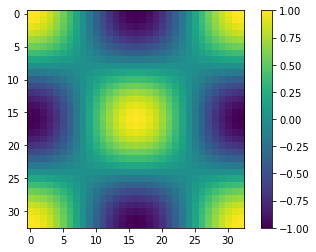

In [5]:
'''Plot the rhs vector v in 2D'''
rhs_f = rhs.reshape(xx.shape)
plt.imshow(rhs_f)
plt.colorbar()

In [6]:
EPS = 1e-6
n_jacobi = 0
u_jacobi = np.zeros((n+1)*(n+1))
res = np.linalg.norm(prob.f - np.dot(prob.A,u_jacobi))
res_jacobi = [res]
while (res>EPS):
    prob.v = u_jacobi
    u_jacobi = prob.Relax(1)
    res = np.linalg.norm(prob.f - np.dot(prob.A,u_jacobi))
    res_jacobi.append(res)
    n_jacobi += 1
    print(n_jacobi, res)

print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

1 15.795043420322997
2 15.592712207365405
3 15.392972622662247
4 15.195791575075454
5 15.001136345246687
6 14.808974599871974
7 14.6192744060182
8 14.432004234593984
9 14.2471329585007
10 14.064629848700658
11 13.884464569553174
12 13.706607173928793
13 13.531028098286358
14 13.357698157778122
15 13.186588541405309
16 13.017670807231434
17 12.85091687765549
18 12.686299034745147
19 12.523789915629557
20 12.363362507951113
21 12.204990145375453
22 12.048646503158968
23 11.894305593773103
24 11.741941762584677
25 11.591529683591569
26 11.443044355213006
27 11.296461096133797
28 11.151755541201778
29 11.008903637377838
30 10.86788163973779
31 10.728666107525493
32 10.591233900256515
33 10.455562173871696
34 10.321628376940009
35 10.189410246910034
36 10.058885806409483
37 9.930033359592093
38 9.802831488531337
39 9.67725904966033
40 9.553295170257316
41 9.430919244976206
42 9.310110932421543
43 9.19085015176734
44 9.073117079419248
45 8.956892145719452
46 8.84215603169378
47 8.72888966584

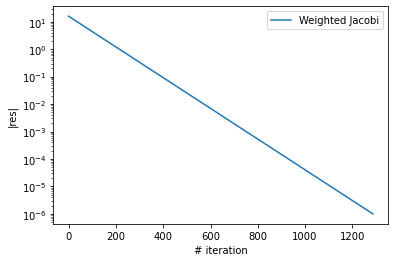

In [7]:
# Plot the residual evolution
plt.plot(res_jacobi, label='Weighted Jacobi')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('# iteration')
plt.ylabel('|res|')
plt.legend()

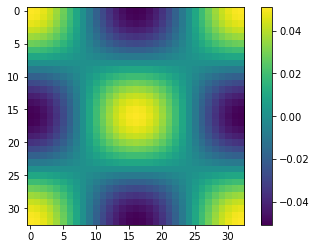

In [8]:
'''Plot the solution vector v in 2D'''
solution = prob.v
uu = solution.reshape(xx.shape)
plt.imshow(uu)
plt.colorbar()

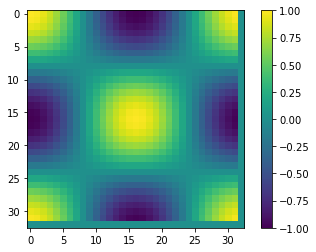

In [9]:
initial_f = prob.f.reshape(xx.shape)
plt.imshow(initial_f)
plt.colorbar()

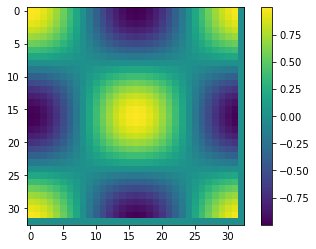

In [10]:
final_f = np.dot(prob.A,prob.v)
final_f = final_f.reshape(xx.shape)
plt.imshow(final_f)
plt.colorbar()